## Importações



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import random

from funcoes import *
from funcoes import selecao_torneio_min as funcao_selecao
from funcoes import cruzamento_ponto_simples as funcao_cruzamento

In [2]:
from mofdb_client import fetch
# Fetch all mofs with void fraction >= 0.5 and <= 0.99
# Convert all isotherm loading units to mmol/g and all pressures to atmospheres

# Create a DataFrame
df = pd.DataFrame()

TAMANHO_DATAFRAME = 5000

t = 0
for mof in fetch(vf_min=0, vf_max=1, loading_unit="mmol/g", pressure_unit="atm"):
    new_row = {'mof': mof.name, 'cif': mof.cif, 'void fraction': mof.void_fraction}
    # Append the new row to the DataFrame
    df = df.append(new_row, ignore_index=True)
    t += 1
    if t >= TAMANHO_DATAFRAME:
        break

## Tratamento de dados

In [3]:
df = extrair_cif(df, minimo = 5)

c:\venv\ilumpy\lib\site-packages\pymatgen\io\cif.py:1134: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


GlobalSymmetryFeatures:   0%|          | 0/5000 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
df.keys()

Index(['mof', 'void fraction', 'spacegroup_num', 'crystal_system_int',
       'n_symmetry_ops', 'Zn', 'H', 'C', 'O', 'F', 'Cl', 'Br', 'N'],
      dtype='object')

## Rede Neural



### Divisão treino-teste

In [5]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455
FEATURES = list(df.iloc[:,2:].keys())

TARGET = ['void fraction'] # porosidade do mof

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
X_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [6]:
normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(X_treino)
normalizador_y.fit(y_treino)

X_treino = normalizador_x.transform(X_treino)
y_treino = normalizador_y.transform(y_treino)
X_teste = normalizador_x.transform(X_teste)
y_teste = normalizador_y.transform(y_teste)

In [7]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [8]:
class MLP(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, neuronios_c3, neuronios_c4, num_targets
    ):
        # Temos que inicializar a classe mãe
        super().__init__()

        # Definindo as camadas da rede
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, neuronios_c3),
                    nn.ReLU(),
                    nn.Linear(neuronios_c3, neuronios_c4),
                    nn.ReLU(),
                    nn.Linear(neuronios_c4, num_targets),
                )

    def forward(self, x):
        """Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [9]:
NUM_DADOS_DE_ENTRADA = X_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 350
NEURONIOS_C2 = 200
NEURONIOS_C3 = 180
NEURONIOS_C4 = 150

minha_MLP = MLP(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NEURONIOS_C3, NEURONIOS_C4, NUM_DADOS_DE_SAIDA)

In [10]:
y_prev = minha_MLP(X_treino)

In [11]:
TAXA_DE_APRENDIZADO = 0.0001

# função perda será o erro quadrático médio
fn_perda = nn.MSELoss()

# otimizador será o Adam, um tipo de descida do gradiente
otimizador = optim.Adam(minha_MLP.parameters(), lr=TAXA_DE_APRENDIZADO)

In [12]:
minha_MLP.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=11, out_features=350, bias=True)
    (1): ReLU()
    (2): Linear(in_features=350, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=180, bias=True)
    (5): ReLU()
    (6): Linear(in_features=180, out_features=150, bias=True)
    (7): ReLU()
    (8): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [13]:
NUM_EPOCAS = 500

y_true = y_treino

epocas = []

loss_functions = []

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_MLP(X_treino)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_pred, y_true)

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # salva os resultados
    #print(epoca, loss.data)
    epocas.append(epoca)
    loss_functions.append(float(loss.data))

In [14]:
with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_MLP(X_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

#for yt, yp in zip(y_true, y_pred):
    #print(yt, yp)

In [15]:
minha_MLP.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=11, out_features=350, bias=True)
    (1): ReLU()
    (2): Linear(in_features=350, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=180, bias=True)
    (5): ReLU()
    (6): Linear(in_features=180, out_features=150, bias=True)
    (7): ReLU()
    (8): Linear(in_features=150, out_features=1, bias=True)
  )
)

In [16]:
verdadeiro = []
previsto = []

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_MLP(X_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    verdadeiro.append(yt)
    previsto.append(yp)

In [17]:
X_teste[0]

tensor([0.0000, 1.0000, 0.0000, 0.0000, 0.0897, 0.1212, 0.0721, 0.0000, 0.0000,
        0.0000, 0.0000])

In [18]:
RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.09351346354386339


## Algoritmo Genético

In [19]:
# Constantes de busca

TAMANHO_POP = 20 # quantidade de indivíduos
NUM_GERACOES = 500 # número de gerações
CHANCE_CRUZAMENTO = 0.5 # chance de ocorrer o cruzamento entre dois indivíduos
CHANCE_MUTACAO = 0.2 # chance de ocorrer mutação em cada indivíduo durante cada geração

# Constantes de problema
QUANTIDADE_MAX_ATOMOS = 200 # quantidade de valor máximo que um gene pode assumir
NUM_ELEMENTOS = len(FEATURES) - 3 # quantidade de genes presentes em cada indivíduo
TAMANHO_PORO_DESEJADO = 0.5

In [20]:
# Funções Locais

def cria_populacao_inicial(tamanho, numero_elementos):
    return populacao_mof(tamanho, numero_elementos, QUANTIDADE_MAX_ATOMOS)

def funcao_mutacao(individuo):
    return mutacao_mof(individuo, QUANTIDADE_MAX_ATOMOS)

def lista_para_dataframe(lista):
    """ Uma função que recebe uma lista e retorna um dataframe, seguindo uma ordem de colunas
    
    Args:
        lista: uma lista qualquer
        
    Return:
        dataframe
    """
    df_lista = pd.DataFrame([lista], columns=FEATURES)
    
    return df_lista

def computa_void_fraction(individuo):
    """ Uma função que calcula o tamanho previsto para uma MOF a partir do modelo de Redes Neurais treinado.
    
    Args:
        individuo: um indivíduo válido para o problema das mofs
        
    Return:
        void_fraction previsto
    """
    individuo = lista_para_dataframe(individuo)
    individuo = normalizador_x.transform(individuo)
    individuo = torch.tensor(individuo, dtype=torch.float32)
    with torch.no_grad():
        y_pred = minha_MLP(individuo)
        y_pred = normalizador_y.inverse_transform(y_pred)
        
    return y_pred

def funcao_objetivo(individuo, tamanho_poro_desejado):
    """ Uma função que calcula o fitness de cada indivíduo do problema das mofs a partir do modelo preditivo de redes neurais
    
    Args:
        individuo: um indivíduo válido para o problema das mofs
        
    Return:
        O fitness do indivíduo
    """
    y_pred = computa_void_fraction(individuo)[0]
    
    return abs(y_pred - tamanho_poro_desejado)

def funcao_objetivo_pop(populacao):
    """ Calcula a função objetivo para todos os membros de uma população
    
    Args:
        população: Lista com todos os indivíduos da população
        
    Return:
        Lista contendo o fitness de cada indivíduo
    """
    fitness = []
    for individuo in populacao:
        fobj = funcao_objetivo(individuo, TAMANHO_PORO_DESEJADO)
        fitness.append(fobj)
    return fitness

In [21]:
populacao = cria_populacao_inicial(TAMANHO_POP, NUM_ELEMENTOS) # cria aleatoriamente uma população inicial
hall_da_fama_individuo = []
geracoes = []
melhor_fitness_ja_visto = float("inf")  # é assim que escrevemos infinito em python

print('População inicial:') # mostra qual foi a população criada aleatoriamente
for i, ind in enumerate(populacao):
    print('Individuo ', i+1, ': ', ind)

for geracao in range(NUM_GERACOES): # loop que começa a rodar cada geração
    fitness = funcao_objetivo_pop(populacao) # cálculo da função objetivo de cada indivíduo da população
    populacao = funcao_selecao(populacao, fitness) # seleção de roleta com diferentes pesos, baseados na função fitness
    
    pais = populacao[0::2] # definição dos indivíduos que serão pais
    maes = populacao[1::2] # definição dos indivíduos que serão mães
    contador = 0 # estratégia para colocar os filhos no lugar dos pais
    for pai, mae in zip(pais, maes): # laço de repetição para pegar itens da lista de pais e mães
        if random.random() < CHANCE_CRUZAMENTO: # aplicando a possibilidade de cruzamento
            # vai acertar o cruzamento
            filho1, filho2 = funcao_cruzamento(pai, mae) # "calculando" o filho 1 e o filho 2
            populacao[contador] = filho1 # trocando o pai pelo filho 1
            populacao[contador + 1] = filho2 # trocando a mãe pelo filho 2
            
        contador = contador + 2 # atualização do contador
    
    for n in range(len(populacao)): #laço de repetição para mutação
        if random.random() <= CHANCE_MUTACAO: # chance de mutação
            individuo = populacao[n] # esxolhe o indivíduo
            populacao[n] = funcao_mutacao(individuo) # muta o indivíduo
            
    #hall da fama       
    fitness = funcao_objetivo_pop(populacao)
    menor_fitness = min(fitness)
    posicao = fitness.index(menor_fitness)
    individuo = populacao[posicao].copy()
    tamanho_poro = computa_void_fraction(individuo)[0]
    if menor_fitness < melhor_fitness_ja_visto:
        melhor_fitness_ja_visto = menor_fitness
        melhor_individuo_ja_visto = individuo
        melhor_tamanho_poro_ja_visto = tamanho_poro
        print(f"Melhor poro: {tamanho_poro}")
        
    hall_da_fama_individuo.append(melhor_tamanho_poro_ja_visto)
    geracoes.append(geracao)
    
print()
print('População final:') # mostra qual foi a população final selecionada geneticamente
for i, ind in enumerate(populacao):
    print('Individuo ', i+1, ': ', ind, computa_void_fraction(ind))

População inicial:
Individuo  1 :  [191, 4, 2, 164, 19, 2, 120, 58, 172, 159, 149]
Individuo  2 :  [62, 5, 12, 90, 129, 149, 80, 6, 191, 51, 194]
Individuo  3 :  [163, 1, 9, 27, 181, 58, 180, 99, 153, 199, 120]
Individuo  4 :  [190, 5, 9, 30, 57, 23, 23, 101, 20, 132, 153]
Individuo  5 :  [123, 4, 4, 191, 181, 181, 56, 153, 13, 125, 32]
Individuo  6 :  [110, 7, 8, 172, 164, 137, 158, 182, 107, 148, 139]
Individuo  7 :  [50, 7, 10, 186, 26, 180, 122, 151, 197, 104, 36]
Individuo  8 :  [152, 3, 1, 85, 3, 4, 5, 43, 60, 39, 62]
Individuo  9 :  [8, 1, 4, 48, 177, 174, 101, 131, 26, 108, 100]
Individuo  10 :  [57, 4, 7, 196, 157, 76, 156, 149, 188, 48, 77]
Individuo  11 :  [85, 2, 6, 162, 5, 176, 171, 85, 2, 122, 47]
Individuo  12 :  [216, 2, 6, 144, 100, 143, 52, 144, 91, 34, 144]
Individuo  13 :  [170, 6, 9, 143, 132, 109, 192, 33, 87, 26, 24]
Individuo  14 :  [73, 5, 11, 121, 107, 40, 199, 193, 177, 9, 192]
Individuo  15 :  [47, 7, 7, 146, 52, 71, 184, 166, 122, 164, 56]
Individuo  16 :  

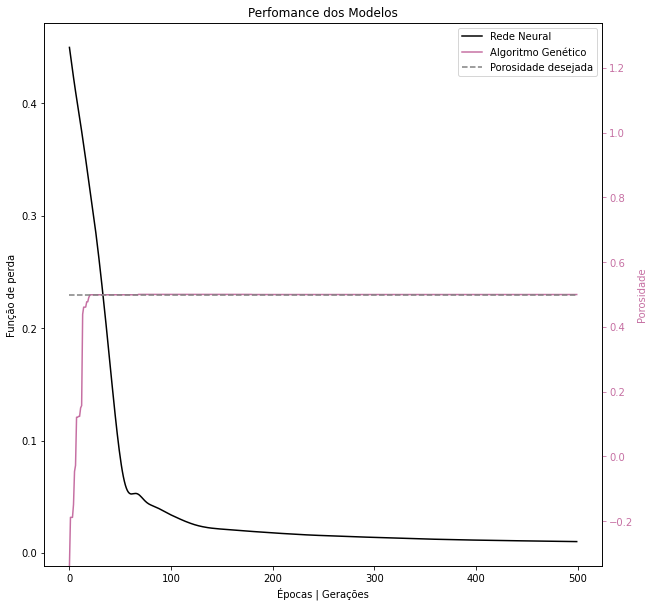

In [22]:
import matplotlib.pyplot as plt

# Create some sample data
x = geracoes
y1 = loss_functions
y2 = hall_da_fama_individuo
y3 = [TAMANHO_PORO_DESEJADO]*len(x)

# Create the first set of axes on the left side
fig, ax1 = plt.subplots(figsize = (10, 10))
ax1.plot(x, y1, 'black', label = 'Rede Neural')
ax1.set_xlabel('Épocas | Gerações')
ax1.set_ylabel('Função de perda', color='black')
ax1.tick_params('y', colors='black')

# Create the second set of axes on the right side
ax2 = ax1.twinx()
ax2.plot(x, y2, '#C670A3', label = 'Algoritmo Genético')
ax2.plot(x, y3, 'gray', linestyle='dashed', label = 'Porosidade desejada')
ax2.set_ylabel('Porosidade', color='#C670A3')
ax2.tick_params('y', colors='#C670A3')
plt.ylim(min(y2), 1 - min(y2))

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.title('Perfomance dos Modelos')

plt.savefig('Modelos MOFs simplificados.png', dpi = 300)
plt.show()

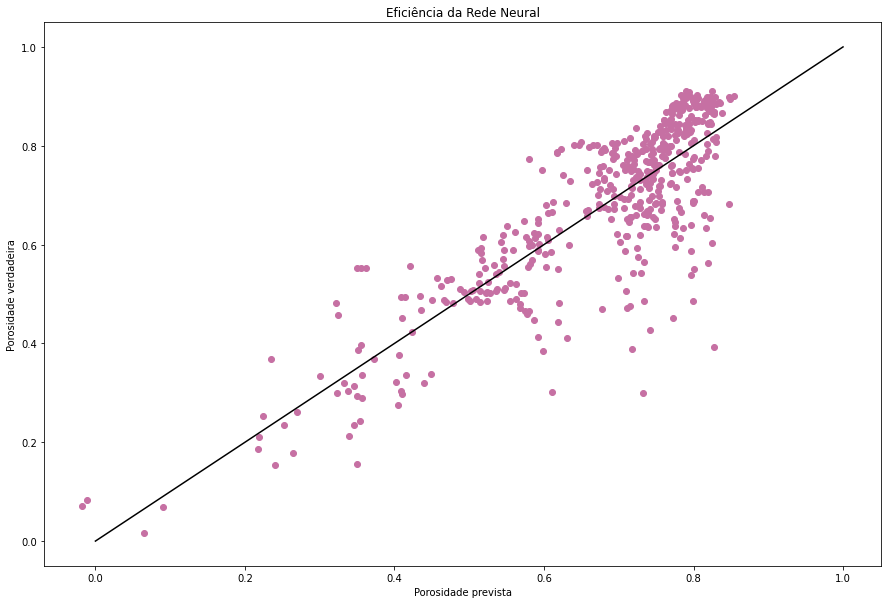

In [24]:
fig = plt.figure(figsize = (15, 10))

identidade = np.linspace(0, 1, 100)

plt.scatter(previsto, verdadeiro, c='#C670A3')

plt.plot(identidade, identidade, c = 'black')
plt.xlabel('Porosidade prevista')
plt.ylabel('Porosidade verdadeira')

plt.title('Eficiência da Rede Neural')

plt.savefig('Eficácia da Rede Neural.png', dpi = 300)

plt.show()